# Import the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("/kaggle/input/brand-laptops-dataset/laptops.csv")

# return the first three rows
df.head(3)

,index,brand,Model,Price,Rating,processor_brand,processor_tier,num_cores,num_threads,ram_memory,...,secondary_storage_type,secondary_storage_capacity,gpu_brand,gpu_type,is_touch_screen,display_size,resolution_width,resolution_height,OS,year_of_warranty
0,1,tecno,Tecno Megabook T1 Laptop (11th Gen Core i3/ 8G...,23990,63,intel,core i3,2,4,8,...,No secondary storage,0,intel,integrated,False,15.6,1920,1080,windows,1
1,2,tecno,Tecno Megabook T1 Laptop (11th Gen Core i7/ 16...,35990,67,intel,core i7,4,8,16,...,No secondary storage,0,intel,integrated,False,15.6,1920,1080,windows,1
2,3,hp,HP Victus 15-fb0157AX Gaming Laptop (AMD Ryzen...,51100,73,amd,ryzen 5,6,12,8,...,No secondary storage,0,amd,dedicated,False,15.6,1920,1080,windows,1


# EDA for Data Modeling

## Data Understanding

In [3]:
df.shape

(991, 22)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   index                       991 non-null    int64  
 1   brand                       991 non-null    object 
 2   Model                       991 non-null    object 
 3   Price                       991 non-null    int64  
 4   Rating                      991 non-null    int64  
 5   processor_brand             991 non-null    object 
 6   processor_tier              991 non-null    object 
 7   num_cores                   991 non-null    int64  
 8   num_threads                 991 non-null    int64  
 9   ram_memory                  991 non-null    int64  
 10  primary_storage_type        991 non-null    object 
 11  primary_storage_capacity    991 non-null    int64  
 12  secondary_storage_type      991 non-null    object 
 13  secondary_storage_capacity  991 non

In [5]:
print("Number of duplicated data:", df.duplicated().sum())

Number of duplicated data: 0


In [6]:
# make the "index" and "Model" columns as indexes
df.set_index(["index", "Model"], inplace=True)

In [7]:
# list of columns to convert to lowercase
columns_to_convert = df.select_dtypes("object").columns 

# convert the values
for column in columns_to_convert:
    if column in df.columns:
        df[column] = df[column].apply(lambda x: x.lower())

In [8]:
# find unique brand name
df["brand"].unique()

array(['tecno', 'hp', 'acer', 'lenovo', 'apple', 'infinix', 'asus',
       'dell', 'samsung', 'msi', 'wings', 'ultimus', 'primebook', 'iball',
       'zebronics', 'chuwi', 'gigabyte', 'jio', 'honor', 'realme',
       'avita', 'microsoft', 'fujitsu', 'lg', 'walker', 'axl'],
      dtype=object)

In [9]:
# find unique storage type name
df["primary_storage_type"].unique()

array(['ssd', 'hdd'], dtype=object)

In [10]:
# converte indian rupees to indonesian rupiah
df["Price"] = df["Price"] * 187.8

## Data Preprocessing

In [11]:
# selecting columns
numeric_columns = df.select_dtypes("number").columns
categorical_columns = df.select_dtypes(exclude=["number"]).columns

# transforming columns
ct = ColumnTransformer([
    ("scaler", StandardScaler(), numeric_columns),
    ("encoder", OneHotEncoder(), categorical_columns)
])

# pipeline
pipeline = Pipeline([
    ("preprocessor", ct)
])

# transforming the data
df_new = pipeline.fit_transform(df)

In [12]:
df_new.shape

(991, 80)

# Clustering

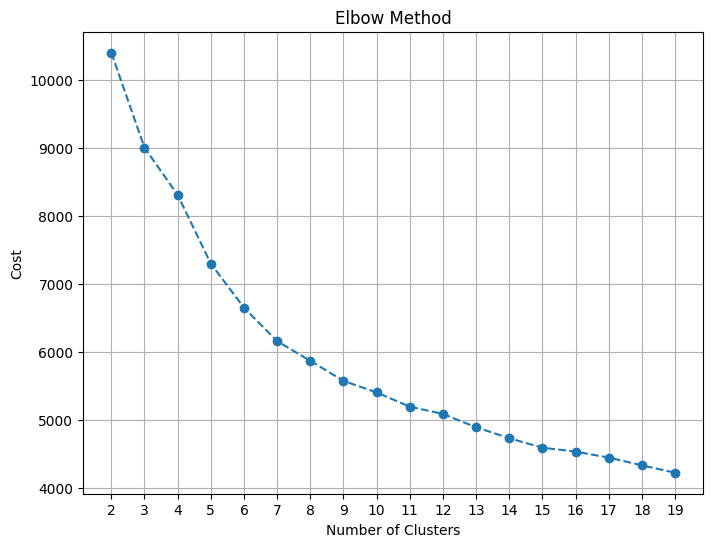

In [13]:
# cost value
cost = []
for i in range(2, 20):
    kmeans = KMeans(n_clusters=i, random_state=2024)
    kmeans.fit_predict(df_new)
    cost.append(kmeans.inertia_)
    
# plotting the elbow method graph
plt.figure(figsize=(8, 6))
plt.plot(range(2, 20), cost, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.xticks(range(2, 20))
plt.grid(True)
plt.show()

In [14]:
# data modeling
kmeans_model = KMeans(n_clusters=9, random_state=2024)
clusters = kmeans_model.fit_predict(df_new)
df["clusters"] = clusters

# mapping the clusters name
df["segmentation"] = df["clusters"].map({
    0: "Cluster A",
    1: "Cluster B",
    2: "Cluster C",
    3: "Cluster D",
    4: "Cluster E",
    5: "Cluster F",
    6: "Cluster G",
    7: "Cluster H",
    8: "Cluster I",
    9: "Cluster J",
})

In [15]:
# save df to csv
df.to_csv('laptop_clustered.csv', index=False)

# PCA

In [16]:
# convert sparse input data to dense array
dense_array = df_new.toarray()

# apply PCA on the dense array
pca = PCA(n_components=2)
df_pca = pca.fit_transform(dense_array)

In [17]:
# create new df
df = pd.DataFrame({
    "x": df_pca[:,0], 
    "y": df_pca[:,1], 
    "label": df["segmentation"]
})

In [18]:
# grouping by label
groups = df.groupby("label")

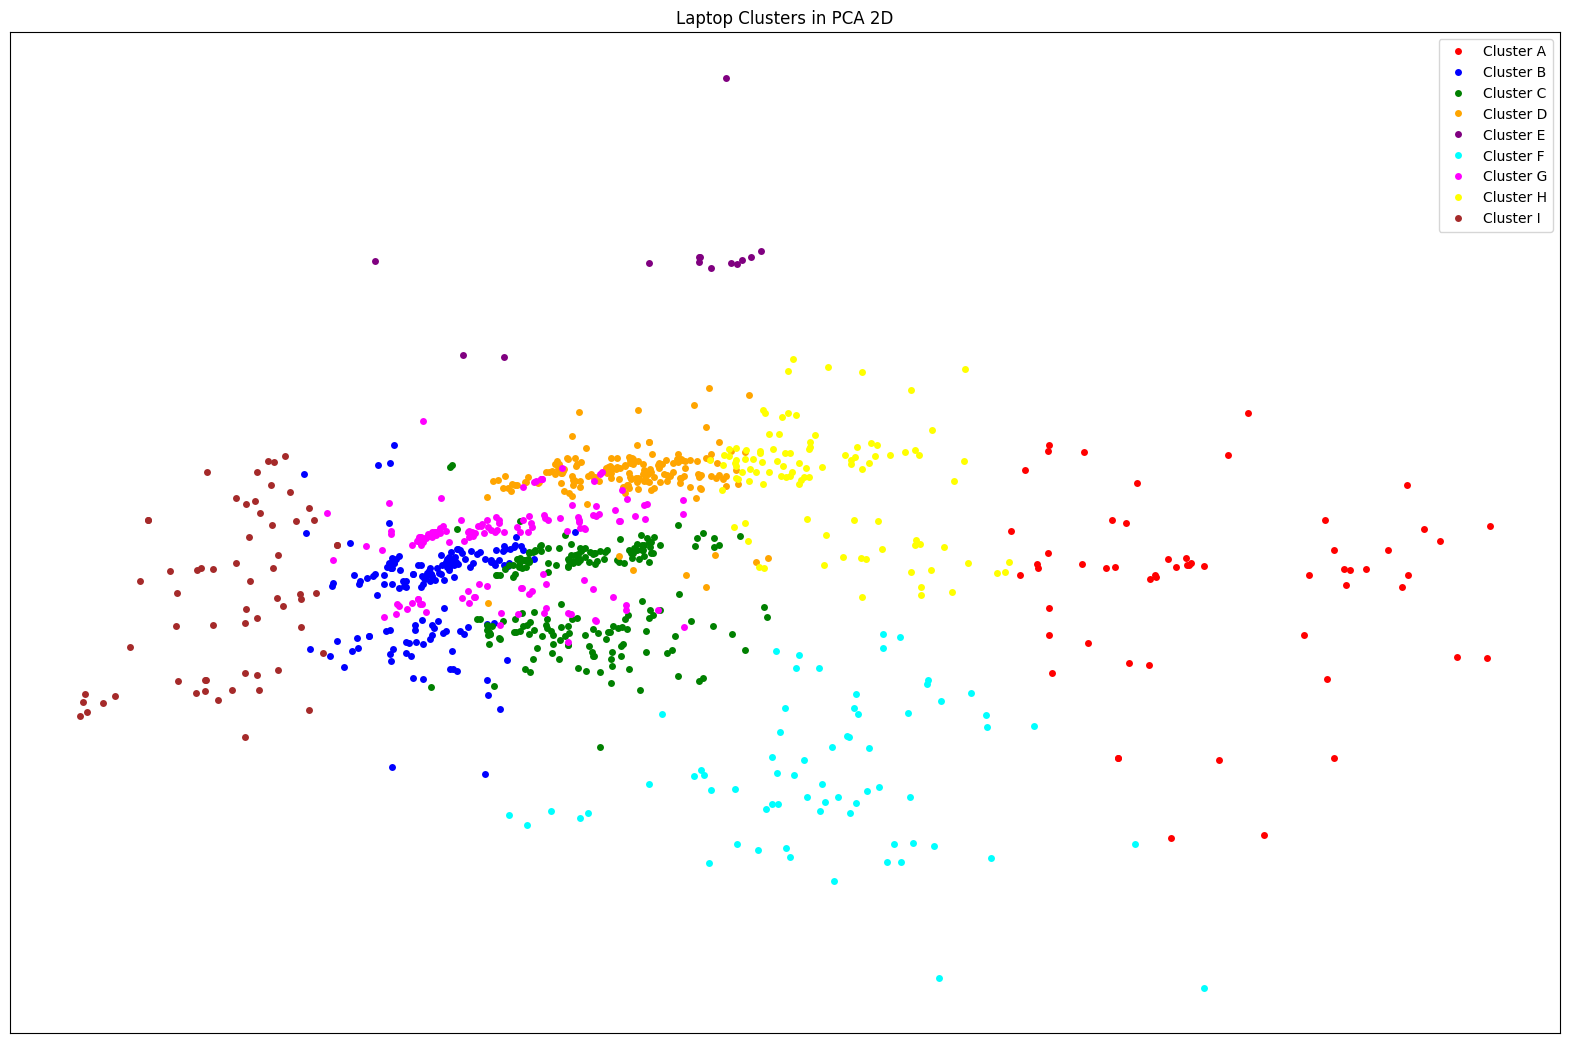

In [19]:
# color mapping for each cluster
colors = {
    "Cluster A": "red",
    "Cluster B": "blue",
    "Cluster C": "green",
    "Cluster D": "orange",
    "Cluster E": "purple",
    "Cluster F": "cyan",
    "Cluster G": "magenta",
    "Cluster H": "yellow",
    "Cluster I": "brown",
    "Cluster J": "black"
}


fig, ax = plt.subplots(figsize=(20, 13)) 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name],label=name, mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    
ax.legend()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("Laptop Clusters in PCA 2D")
plt.show()

__Credit:__ Saba Naseem Butt for the PCA visualization documentation